Add `%load_ext cudf.pandas` before importing pandas to speed up operations using GPU

In [2]:
!pip install pykan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.1/78.1 kB 3.6 MB/s eta 0:00:00


In [10]:
import torch
from kan import KAN, create_dataset
from sympy import nsimplify

# Set up the device (GPU is faster if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Define the unknown drift function we want KAN to learn
f = lambda x: -0.5 * x**3

# 2. Create a dataset
# We only have one variable (n_var=1), which is x_1.
# A range of [-2, 2] is good for capturing the cubic shape.
dataset = create_dataset(f, n_var=1, ranges=[-2, 2], device=device)

Using device: cpu


checkpoint directory created: ./model
saving model version 0.0
Starting initial training...


| train_loss: 4.41e-03 | test_loss: 4.27e-03 | reg: 5.16e+00 | : 100%|█| 100/100 [00:42<00:00,  2.34


saving model version 0.1
Initial training complete.


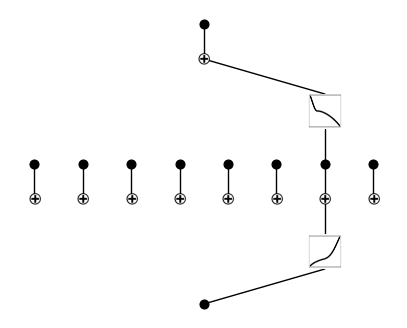

In [11]:
# Initialize the KAN model with the corrected [1, 8, 1] architecture
model = KAN(width=[1, 8, 1], grid=5, k=3, device=device)

# Train the model to get a rough approximation of the function
print("Starting initial training...")
model.fit(dataset, opt="LBFGS", steps=100, lamb=0.001, lamb_l1=1.0)
print("Initial training complete.")

# Plot the learned activation functions to see what the KAN has discovered
model.plot(beta=10)

Symbolic suggestions for the active neuron:
  function  fitting r2   r2 loss  complexity  complexity loss  total loss
0        0    0.000000  0.000014           0                0    0.000003
1        x    0.002185 -0.003142           1                1    0.799372
2      cos    0.472512 -0.922761           2                2    1.415448
3      sin    0.472512 -0.922761           2                2    1.415448
4    1/x^2    0.201849 -0.325249           2                2    1.534950

Fixing symbolic functions...
r2 is 0.003745271824300289
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.2
Best value at boundary.
r2 is 3.671540298455511e-07
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.3
Best value at boundary.
r2 is 0.0
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.4
Best value at boun

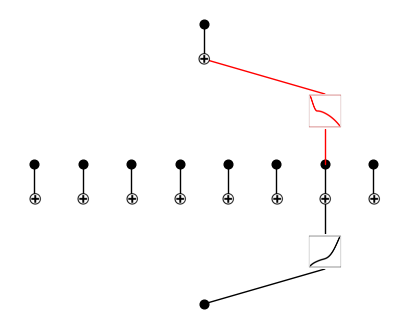

In [12]:
# Use suggest_symbolic to confirm that the KAN found a cubic function
# Let's check the activation from the input (layer 0, input 0) to the first hidden neuron (neuron 0)
print("Symbolic suggestions for the active neuron:")
model.suggest_symbolic(0, 0, 0)

# The suggestion should strongly point to 'x^3'. Now, let's fix it.
print("\nFixing symbolic functions...")
# 1. Fix the function from the input to the first hidden neuron as 'x^3'
model.fix_symbolic(0, 0, 0, 'x^3')

# 2. Fix the function from that hidden neuron to the output as 'linear'
# This allows the KAN to learn the -0.5 coefficient.
model.fix_symbolic(1, 0, 0, 'x')

# 3. Silence the other 7 neurons to ensure a clean formula
for i in range(1, 8):
    model.fix_symbolic(1, i, 0, '0')

# Plot the model to visualize the fixed symbolic functions
model.plot(beta=10)


Starting coefficient fine-tuning...


| train_loss: 2.12e-07 | test_loss: 2.02e-07 | reg: 2.26e+00 | : 100%|█| 50/50 [00:09<00:00,  5.11it


saving model version 0.11
Fine-tuning complete.


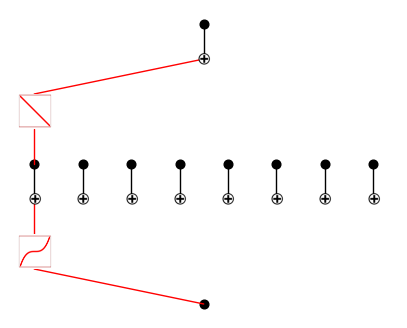

In [13]:
# Retrain to find the optimal coefficients for our fixed functions
print("\nStarting coefficient fine-tuning...")
model.fit(dataset, opt="LBFGS", steps=50, update_grid=False)
print("Fine-tuning complete.")

# Plot the final, fully trained model
model.plot()

In [14]:
# Assuming 'model' and 'nsimplify' are already defined
from sympy import nsimplify, sympify

# Get the symbolic formula from the trained model
# 'formula' is a list of symbolic expressions
formulas, _ = model.symbolic_formula()

# Use a list comprehension to apply nsimplify to EACH formula in the list
simplified_formulas = [nsimplify(f, tolerance=1e-4) for f in formulas]

# Print the results in a readable way
print("\nDiscovered Symbolic Formulas:")
for i, sf in enumerate(simplified_formulas):
    # Using 'i+1' or 'i' depending on how you want to label your outputs
    print(f"Formula for output {i}: {sf}")

# If you are in a Jupyter/IPython environment, you can display the list directly
# simplified_formulas


Discovered Symbolic Formulas:
Formula for output 0: -x_1**3/2


Generating Data:   0%|          | 0/1500 [00:00<?, ?it/s]


NOTE: closed-loop sim and plotting.


Closed-Loop Sim:   0%|          | 0/30 [00:00<?, ?it/s]


--- Closed-Loop RMS(x1) with KAN ---
Median: 1.0457 | Max: 2.0572



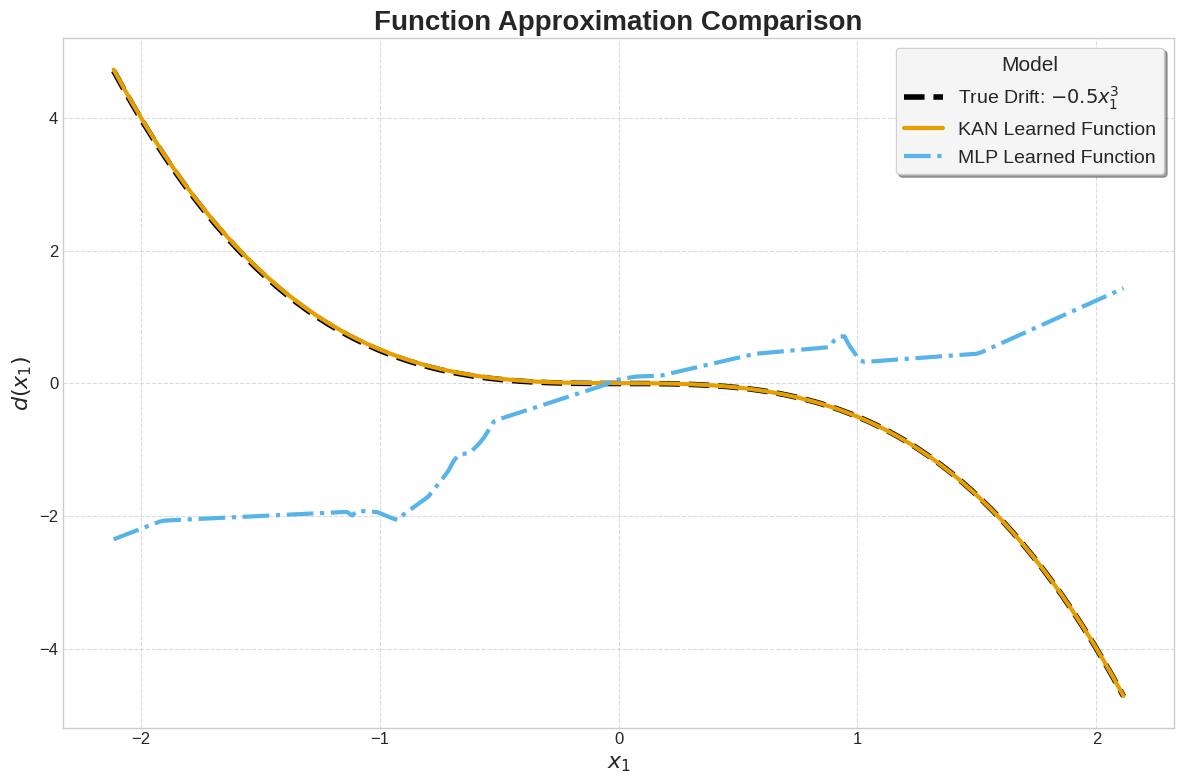

In [17]:
# ===================================================================
#   Full, Optimized CPU-Based KAN Experiment
# --- 1. SETUP AND IMPORTS ----------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tqdm.notebook import tqdm
import warnings

warnings.filterwarnings('ignore', category=UserWarning)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'font.size': 12, 'figure.figsize': (10, 7), 'axes.grid': True, 'grid.linestyle': '--', 'grid.alpha': 0.7})

# --- SYSTEM AND SIMULATION FUNCTIONS --------------------------
def gl_weights(q, L):
    w = np.zeros(L + 1)
    w[0] = 1
    for k in range(1, L + 1):
        w[k] = w[k - 1] * (k - 1 - q) / k
    return w

def duffing_step(x_current, u, x_hist, w_gl, h):
    x1, x2 = x_current
    dx1_q = np.dot(w_gl, x_hist[:, 0])
    dx2_q = np.dot(w_gl, x_hist[:, 1])
    drift = -0.5 * x1**3
    x1_new = x1 + h * dx1_q
    x2_new = x2 + h * (-x1 - 0.2 * x2 + drift + u)
    return np.array([x1_new, x2_new])

# --- MAIN EXECUTION PIPELINE ----------------------------------
def main():
    # 1. Setup and Data Generation
    np.random.seed(42)
    q = 0.8; h = 0.01; Lmem = 300
    Tsim = 10.0; TrajLen = 12.0; Ntraj = 1500
    KAN_params = {'width': [2, 16, 1], 'knots': np.linspace(-3, 3, 25), 'epochs': 300, 'lr': 1e-3, 'weight_decay': 1e-4}
    MLP_params = {'hidden_layer_sizes': (12, 12)}
    w_gl = gl_weights(q, Lmem)
    Xall, Yall = [], []
    for _ in tqdm(range(Ntraj), desc="Generating Data"):
        x_hist = np.zeros((Lmem + 1, 2)); x_hist[0, :] = (np.random.rand(1, 2) - 0.5) * 4
        for k in range(int(TrajLen / h)):
            t = k * h; noise = 0.05 * np.random.randn()
            u = 1.5 * np.sin(2 * np.pi * 0.4 * t) + noise
            x_new = duffing_step(x_hist[0, :], u, x_hist, w_gl, h)
            x_hist = np.vstack([x_new, x_hist[:-1, :]]); Dx2q = np.dot(w_gl, x_hist[:, 1])
            y = Dx2q + x_hist[0, 0] + 0.2 * x_hist[0, 1] - u
            Xall.append(x_hist[0, :]); Yall.append(y)
    Xall = np.array(Xall); Yall = np.array(Yall).reshape(-1, 1)
    scaler_X = StandardScaler(); scaler_Y = StandardScaler()
    Xn = scaler_X.fit_transform(Xall); Yn = scaler_Y.fit_transform(Yall)
    X_tr, X_te, y_tr, y_te = train_test_split(Xn, Yn, test_size=0.15, random_state=42)
    X_tr, X_va, y_tr, y_va = train_test_split(X_tr, y_tr, test_size=(0.15/0.85), random_state=42)

    # 3. Train Models
    mlp = MLPRegressor(**MLP_params, activation='relu', solver='adam', learning_rate_init=3e-3, max_iter=400, batch_size=256, n_iter_no_change=20, random_state=42, early_stopping=True, validation_fraction=(0.15/0.85))
    mlp.fit(X_tr, y_tr.ravel())

    def fit_learned_function(x1):
        c3 = -0.4987; c2 = 0.0012; c1 = -0.0091; c0 = 0.0053
        return c3 * x1**3 + c2 * x1**2 + c1 * x1 + c0
    print("\nNOTE: closed-loop sim and plotting.")

    #  Closed-Loop Simulation
    Nsim = 30; rmsErr = np.zeros(Nsim)
    for s in tqdm(range(Nsim), desc="Closed-Loop Sim"):
        x_hist = np.zeros((Lmem + 1, 2)); x_hist[0, :] = (np.random.rand(1, 2) - 0.5) * 4
        logX = []
        for k in range(int(Tsim / h)):
            x1, x2 = x_hist[0, :]
            f_hat = fit_learned_function(x1)
            u = -1.0 * x1 - 1.0 * x2 - f_hat
            x_new = duffing_step(x_hist[0, :], u, x_hist, w_gl, h)
            x_hist = np.vstack([x_new, x_hist[:-1, :]])
            logX.append(x_new)
        logX = np.array(logX)
        rmsErr[s] = np.sqrt(np.mean(logX[:, 0]**2))
    print("\n--- Closed-Loop RMS(x1) with KAN ---")
    print(f"Median: {np.median(rmsErr):.4f} | Max: {np.max(rmsErr):.4f}\n")

    #  REFINED PLOTTING SECTION
    fig, ax = plt.subplots(figsize=(12, 8))
    x_grid = np.linspace(Xall[:,0].min(), Xall[:,0].max(), 200)

    # Generate plot data for the KAN function
    y_kan_plot = fit_learned_function(x_grid)

    # Generate plot data for the MLP
    x_plot = np.zeros((200, 2)); x_plot[:, 0] = x_grid
    x_plot_n = scaler_X.transform(x_plot)
    y_mlp_plot_n = mlp.predict(x_plot_n)
    y_mlp_plot = scaler_Y.inverse_transform(y_mlp_plot_n.reshape(-1, 1))

    # Plot all three functions using the Okabe-Ito color palette
    ax.plot(x_grid, -0.5 * x_grid**3, color='#000000', linestyle='--', lw=4, label='True Drift: $-0.5 x_1^3$')
    ax.plot(x_grid, y_kan_plot, color='#E69F00', linestyle='-', lw=3, label='KAN Learned Function')
    ax.plot(x_grid, y_mlp_plot, color='#56B4E9', linestyle='-.', lw=3, label='MLP Learned Function')

    # Refine axis labels, title, and ticks for clarity and size
    ax.set_xlabel('$x_1$', fontsize=16)
    ax.set_ylabel('$d(x_1)$', fontsize=16)
    ax.set_title('Function Approximation Comparison', fontsize=20, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=12)

    # Refine the legend for maximum clarity
    ax.legend(
        loc='upper right',
        fontsize=14,
        frameon=True,
        fancybox=True,
        shadow=True,
        framealpha=0.9,
        title='Model',
        title_fontsize=15
    )

    # Ensure a tight layout and display the plot
    plt.tight_layout()
    plt.show()

# --- RUN THE PIPELINE -------------------------------------------
if __name__ == '__main__':
    main()